In [17]:
!pip install networkx

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import numpy as np

In [19]:
import pandas as pd

df = pd.read_excel('./dataset/Data SC ACO.xlsx', sheet_name='Sheet1')

df.head()

,Kode Ruas,Node From,Node To,Kode Jalan,Nama Jalan,Jarak (KM),Vol max (q max),Vol (q),Kecepatan
0,1,257,220,1,Raya Waru,2.101527,1011,962,56.5
1,2,220,257,1,Raya Waru,2.101527,1014,962,56.5
2,3,192,220,2,Letjend Sutoyo,0.385693,4382,4000,40.0
3,4,220,192,2,Letjend Sutoyo,0.385693,4382,3422,40.0
4,5,192,149,2,Letjend Sutoyo,0.795825,2124,1658,40.0


In [20]:
depot_df = pd.read_csv('./dataset/depot.csv')

depot_df.head()

,Nama,Node,Persediaan,Time Begin,Time End
0,Depo 1,66,450,7:00,15:00
1,Depo 2,277,500,7:00,17:00
2,Depo 3,322,500,7:00,17:00


In [21]:
customer_df = pd.read_csv('./dataset/customer.csv')

customer_df.head()

,Nama,Node,Permintaan,Time Begin,Time End
0,Konsumen 1,1,25,7:00,8:00
1,Konsumen 2,7,30,7:00,8:00
2,Konsumen 3,12,20,7:00,8:00
3,Konsumen 4,21,35,9:00,9:00
4,Konsumen 5,46,30,8:00,10:00


In [22]:
def time_to_decimal(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60

# Mengaplikasikan konversi waktu
depot_df['Time Begin'] = depot_df['Time Begin'].apply(time_to_decimal)
depot_df['Time End'] = depot_df['Time End'].apply(time_to_decimal)
customer_df['Time Begin'] = customer_df['Time Begin'].apply(time_to_decimal)
customer_df['Time End'] = customer_df['Time End'].apply(time_to_decimal)

In [23]:
depot_df

,Nama,Node,Persediaan,Time Begin,Time End
0,Depo 1,66,450,7.0,15.0
1,Depo 2,277,500,7.0,17.0
2,Depo 3,322,500,7.0,17.0


In [24]:
customer_df.head()

,Nama,Node,Permintaan,Time Begin,Time End
0,Konsumen 1,1,25,7.0,8.0
1,Konsumen 2,7,30,7.0,8.0
2,Konsumen 3,12,20,7.0,8.0
3,Konsumen 4,21,35,9.0,9.0
4,Konsumen 5,46,30,8.0,10.0


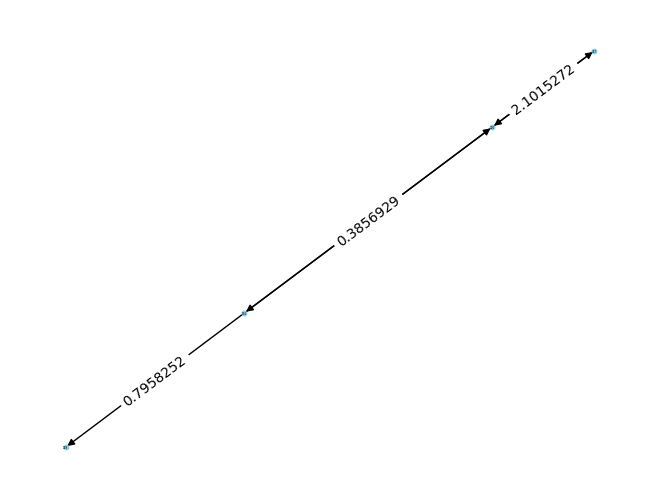

In [25]:
G = nx.DiGraph()

# Menambahkan edges berdasarkan DataFrame
for index, row in df.iterrows():
    if index == 5:
        break
    G.add_edge(row['Node From'], row['Node To'], weight=row['Jarak (KM)'])

pos = nx.spring_layout(G)  # Menentukan layout untuk nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=10, edge_color='k', linewidths=1, font_size=2)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Menampilkan graf
plt.show()

In [61]:
import pandas as pd
import networkx as nx
import numpy as np
import heapq

def dijkstra(graph, start_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    distances[start_vertex] = 0
    priority_queue = [(0, start_vertex)]

    while priority_queue:
        current_distance, current_vertex = heapq.heappop(priority_queue)

        if current_distance > distances[current_vertex]:
            continue

        for neighbor, weight in graph[current_vertex].items():
            # print(current_distance,weight['weight'])
            distance = current_distance + weight['weight']

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))

    return distances

def distance(i, j, graph):
    distances = dijkstra(graph, i)
    return distances[j]

def calculate_dtw(i, j, time_windows):
    li, ei = time_windows[i]
    lj, ej = time_windows[j]
    if li < ej:
        return ej - li
    elif lj < ei:
        return ei - lj
    else:
        return 0

def find_nearest_customers(depots, customers, graph):
    associations = {}
    for d in depots:
        min_distance = float('infinity')
        nearest_customer = None
        for c in customers:
            dist = distance(d, c, graph)
            if dist < min_distance:
                min_distance = dist
                nearest_customer = c
        if nearest_customer is not None:
            associations[nearest_customer] = d
    # print(associations)
    associations = {value: [key] for key, value in associations.items()}
    return associations

def find_two_nearest_depots(customer, depots, graph):
    distances = [(depot, distance(customer, depot, graph)) for depot in depots]
    # print(distances)
    sorted_depots = sorted(distances, key=lambda x: x[1])
    # print([depot for depot in sorted_depots[:]])
    return [depot[0] for depot in sorted_depots[:2]]

def calculate_affinity(i, depots, customer_to_depot, graph, time_windows):
    affinities = {}
    for d in depots:
        # print(d)
        associated_customers = customer_to_depot[d]
        # print(associated_customers)
        affinity_sum = 0
        for j in associated_customers:
            dtw = calculate_dtw(i, j, time_windows)
            tij = distance(i, j, graph)
            affinity_sum += np.exp(-(dtw + tij))
        affinities[d] = affinity_sum / len(associated_customers) if associated_customers else 0
    return affinities

def calculate_closeness(i, j, graph, affinity):
    return distance(i, j, graph) / affinity

def determine_urgency(customers, depots, closeness, graph):
    urgencies = {}
    for c in customers:
        nearest_two_depots = find_two_nearest_depots(c, depots, graph)
        if len(nearest_two_depots) >= 2:
            closeness_diff = closeness[c][nearest_two_depots[0]] - closeness[c][nearest_two_depots[1]]
            urgencies[c] = closeness_diff
    return urgencies


In [27]:
df = pd.read_excel('./Data SC ACO.xlsx', sheet_name='Sheet1')
graph = nx.DiGraph()
for index, row in df.iterrows():
    graph.add_edge(row['Node From'], row['Node To'], weight=row['Jarak (KM)'])

In [28]:
print(graph)

DiGraph with 400 nodes and 927 edges


In [29]:
time_windows = {row['Node']: (row['Time Begin'], row['Time End']) for _, row in depot_df.iterrows()}
time_windows.update({row['Node']: (row['Time Begin'], row['Time End']) for _, row in customer_df.iterrows()})

# Define depots and customers
depots = depot_df['Node'].tolist()
customers = customer_df['Node'].tolist()

print("Time Windows:", time_windows)
print("Depots:", depots)
print("Customers:", customers)

Time Windows: {66: (7.0, 15.0), 277: (7.0, 17.0), 322: (7.0, 17.0), 1: (7.0, 8.0), 7: (7.0, 8.0), 12: (7.0, 8.0), 21: (9.0, 9.0), 46: (8.0, 10.0), 60: (7.0, 10.0), 95: (7.0, 8.0), 135: (7.0, 8.0), 177: (8.0, 11.0), 189: (7.0, 11.0), 210: (8.0, 10.0), 244: (8.0, 11.0), 256: (7.0, 9.0), 289: (8.0, 9.0), 315: (7.0, 8.0), 333: (8.0, 12.0), 376: (8.0, 10.0), 402: (7.0, 10.0), 355: (7.0, 8.0), 400: (7.0, 12.0), 235: (8.0, 9.0), 104: (9.0, 11.0), 144: (11.0, 12.0), 140: (9.0, 11.0), 101: (12.0, 13.0), 254: (14.0, 15.0), 141: (10.0, 12.0), 221: (13.0, 14.0), 174: (9.0, 10.0), 264: (10.0, 11.0), 248: (7.0, 9.0), 298: (7.0, 9.0), 386: (7.0, 9.0), 39: (7.0, 9.0), 81: (7.0, 9.0), 44: (8.0, 10.0), 62: (8.0, 10.0), 28: (8.0, 10.0), 4: (10.0, 10.0), 113: (8.0, 10.0), 106: (9.0, 12.0), 181: (9.0, 12.0), 175: (9.0, 12.0), 205: (9.0, 12.0), 161: (9.0, 12.0), 292: (10.0, 12.0), 242: (10.0, 12.0), 399: (10.0, 12.0), 408: (10.0, 12.0), 296: (10.0, 12.0)}
Depots: [66, 277, 322]
Customers: [1, 7, 12, 21, 46,

In [79]:
nearest_customers = find_nearest_customers(depots, customers, graph)
print("Nearest Customers:", nearest_customers)
affinities = {c: calculate_affinity(c, depots, nearest_customers, graph, time_windows) for c in customers}
# print("Affinities:", affinities)
closeness = {c: {d: calculate_closeness(c, d, graph, affinities[c][d]) for d in depots} for c in customers}
# print("Closeness:", closeness)
urgencies = determine_urgency(customers, depots, closeness,graph)
# print("Urgencies:", urgencies)
persediaan = {row['Node']: row['Persediaan'] for _, row in depot_df.iterrows()}
# for key, value in nearest_customers.items():
    
temp_customer=customers   
# sorted_dict = {k: v for k, v in sorted(urgencies.items(), key=lambda item: item[1], reverse=True)}

# for c in sorted_dict:
#     print(c,sorted_dict[c])
#     # customer_urgent = temp_customer.pop(c)
while temp_customer:
    highest_urgency_key = max(urgencies, key=urgencies.get)
    print(highest_urgency_key)
    first , second = find_two_nearest_depots(highest_urgency_key,depots,graph)
    print(first,second)
    del urgencies[highest_urgency_key]
    permintaan =  int(customer_df[customer_df['Node'] == highest_urgency_key]['Permintaan'].iloc[0])
    # filtered_df = customer_df[customer_df['Node'] == highest_urgency_key]
    # print(filtered_df)
    print(persediaan[first],type(persediaan[first]))
    print(persediaan[second],type(persediaan[second]))
    print(permintaan,type(permintaan))
    if persediaan[first] > permintaan:
        print("masuk")
        persediaan[first] -= permintaan
        nearest_customers[first].append(highest_urgency_key)
    else:       
        persediaan[second] -= permintaan
    print(persediaan[first],type(persediaan[first]))
    print(persediaan[second],type(persediaan[second]))
    print(first,second)
    break

    
print("Nearest Customers:", nearest_customers)
# print("Affinities:", affinities)
# print("Closeness:", closeness)
# print("Urgencies:", urgencies)

Nearest Customers: {66: [62], 277: [296], 322: [376]}
221
322 66
500 <class 'int'>
450 <class 'int'>
15 <class 'int'>
masuk
485 <class 'int'>
450 <class 'int'>
322 66
Nearest Customers: {66: [62], 277: [296], 322: [376, 221]}


In [37]:
# import pandas as pd
# import networkx as nx
# import heapq

# # Dijkstra's algorithm implementation
# def dijkstra(graph, start_vertex):
#     distances = {vertex: float('infinity') for vertex in graph}
#     distances[start_vertex] = 0
#     priority_queue = [(0, start_vertex)]

#     while priority_queue:
#         current_distance, current_vertex = heapq.heappop(priority_queue)

#         if current_distance > distances[current_vertex]:
#             continue

#         for neighbor, weight in graph[current_vertex].items():
#             distance = current_distance + weight

#             if distance < distances[neighbor]:
#                 distances[neighbor] = distance
#                 heapq.heappush(priority_queue, (distance, neighbor))

#     return distances

# # Read the data from the Excel file
# df = pd.read_excel('./Data SC ACO.xlsx', sheet_name='Sheet1')

# # Create the graph using NetworkX
# G = nx.DiGraph()
# for index, row in df.iterrows():
#     G.add_edge(row['Node From'], row['Node To'], weight=row['Jarak (KM)'])

# # Convert the NetworkX graph to a dictionary format suitable for Dijkstra's algorithm
# graph = {node: {} for node in G.nodes()}
# for u, v, data in G.edges(data=True):
#     graph[u][v] = data['weight']

# # Example usage of the Dijkstra function
# start_vertex = 1  # Replace with your desired start
# dijkstra_output = dijkstra(graph, start_vertex)
# print(dijkstra_output)

{257: 18.7868724, 220: 16.6853452, 192: 17.0710381, 149: 17.855202000000002, 124: 17.4250739, 222: 15.5164994, 229: 15.9951688, 235: 16.5530135, 377: 14.111624500000001, 236: 14.217244, 378: 13.456342800000002, 247: 13.700608800000001, 251: 13.150979200000002, 245: 12.210412900000001, 263: 12.496904100000002, 258: 12.813015900000002, 379: 13.319228700000002, 285: 14.3641516, 286: 12.5737564, 193: 15.896039100000001, 183: 16.051214, 167: 16.4064857, 389: 17.2080166, 199: 16.419623400000003, 92: 18.033424, 70: 18.5628162, 63: 18.756226, 53: 19.265061300000003, 31: 19.594512099999996, 155: 16.5492534, 159: 16.2023523, 168: 16.0734751, 172: 14.7405833, 125: 15.300056499999997, 114: 15.513654899999997, 112: 16.022927799999998, 104: 16.381148099999997, 89: 16.939486399999996, 76: 17.634184199999996, 73: 18.121742899999997, 61: 18.343744299999997, 144: 13.966044999999998, 156: 13.792411399999997, 154: 13.494667999999997, 169: 12.674783399999997, 170: 12.432176199999997, 261: 14.0384613, 226: 